<a href="https://colab.research.google.com/github/margherita-tar/snli-textual-entailment/blob/main/SNLI_entailment_Taruchi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchmetrics pytorch-lightning scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 49.5 MB/s eta 0:00:00


In [ ]:
# IMPORT DELLE LIBRERIE

# Librerie di sistema e gestione file
import os
import requests
import zipfile
from collections import Counter

# Librerie per manipolazione Dati
import numpy as np
import pandas as pd

# Librerie per visualizzazione dati
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing, Feature Engineering e Metriche
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Matrici Sparse
from scipy.sparse import csr_matrix, hstack

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping

# TorchMetrics
import torchmetrics

print("Librerie caricate")

Librerie caricate


In [ ]:
# DOWNLOAD DATASET

def download_snli():
    url = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
    zip_path = "snli_1.0.zip"
    response = requests.get(url)

    # Download file ZIP
    if not os.path.exists(zip_path):
      with open(zip_path, 'wb') as f:
        f.write(response.content)

    # Estrazione file ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

    return "snli_data/snli_1.0"

In [ ]:
data_folder = download_snli()

# Caricamento dataset in Pandas
def load_snli_data(file_path):
  return pd.read_csv(file_path, sep="\t", quoting=3)

data_folder = "snli_1.0"

# Visualizzazione prime 10 righe
train_df = load_snli_data(os.path.join(data_folder, "snli_1.0_train.txt"))
dev_df = load_snli_data(os.path.join(data_folder, "snli_1.0_dev.txt"))
test_df = load_snli_data(os.path.join(data_folder, "snli_1.0_test.txt"))

train_df.head(10)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN
5,contradiction,( Children ( ( ( smiling and ) waving ) ( at c...,( ( The kids ) ( are frowning ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (DT The) (NNS kids)) (VP (VBP are...,Children smiling and waving at camera,The kids are frowning,2267923837.jpg#2,2267923837.jpg#2r1c,contradiction,NaN,NaN,NaN,NaN
6,contradiction,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( ( skates down ) ( the sidewa...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ skate...,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,3691670743.jpg#0,3691670743.jpg#0r1c,contradiction,NaN,NaN,NaN,NaN
7,entailment,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( does ( a ( skateboarding tri...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ does)...,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,3691670743.jpg#0,3691670743.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
8,neutral,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( is ( wearing ( safety equipm...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ is) (...,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.,3691670743.jpg#0,3691670743.jpg#0r1n,neutral,NaN,NaN,NaN,NaN
9,neutral,( ( An ( older man ) ) ( ( ( sits ( with ( ( h...,( ( An ( older man ) ) ( ( ( drinks ( his juic...,(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...,4804607632.jpg#0,4804607632.jpg#0r1n,neutral,NaN,NaN,NaN,NaN


Dimensione set di train
(550152, 14)

Dimensioe set di validation
(10000, 14)

Dimensione set di test
(10000, 14)

 Calcolo delle percentuali:
Percentuale Train: 96.49%
Percentuale Validation: 1.75%
Percentuale Test: 1.75%

Tipo di dato
gold_label                object
sentence1_binary_parse    object
sentence2_binary_parse    object
sentence1_parse           object
sentence2_parse           object
sentence1                 object
sentence2                 object
captionID                 object
pairID                    object
label1                    object
label2                    object
label3                    object
label4                    object
label5                    object
dtype: object


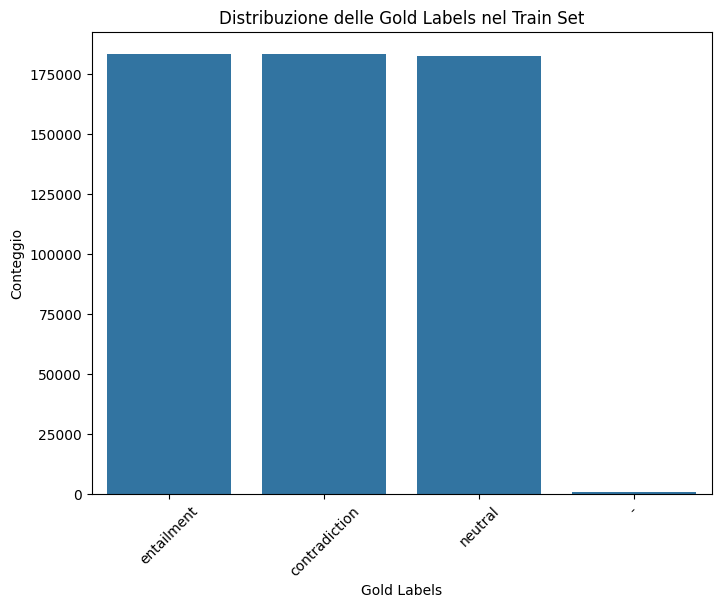

In [ ]:
#EDA

print('Dimensione set di train')
print(train_df.shape)

print('\nDimensioe set di validation')
print(dev_df.shape)

print('\nDimensione set di test')
print(test_df.shape)

print('\n Calcolo delle percentuali:')

# Numero di righe per ogni DataFrame
num_train = len(train_df)
num_dev = len(dev_df)
num_test = len(test_df)

# Calcolo totale dei record
totale_record = num_train + num_dev + num_test

if totale_record > 0:
    # Calcolo percentuali
    perc_train = (num_train / totale_record) * 100
    perc_dev = (num_dev / totale_record) * 100
    perc_test = (num_test / totale_record) * 100

    print(f'Percentuale Train: {perc_train:.2f}%')
    print(f'Percentuale Validation: {perc_dev:.2f}%')
    print(f'Percentuale Test: {perc_test:.2f}%')
else:
    print('I DataFrame sono vuoti, impossibile calcolare le percentuali.')

print('\nTipo di dato')
print(train_df.dtypes)

# Distribuzione delle etichette 'gold_label' nel train_df
label_counts = train_df["gold_label"].value_counts()

# Crezione istogramma
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle Gold Labels nel Train Set")
plt.xlabel("Gold Labels")
plt.ylabel("Conteggio")
plt.xticks(rotation=45)
plt.show()

Train Set:
Lunghezza media delle frasi in sentence1: 12.85 parole
Lunghezza media delle frasi in sentence2: 7.42 parole


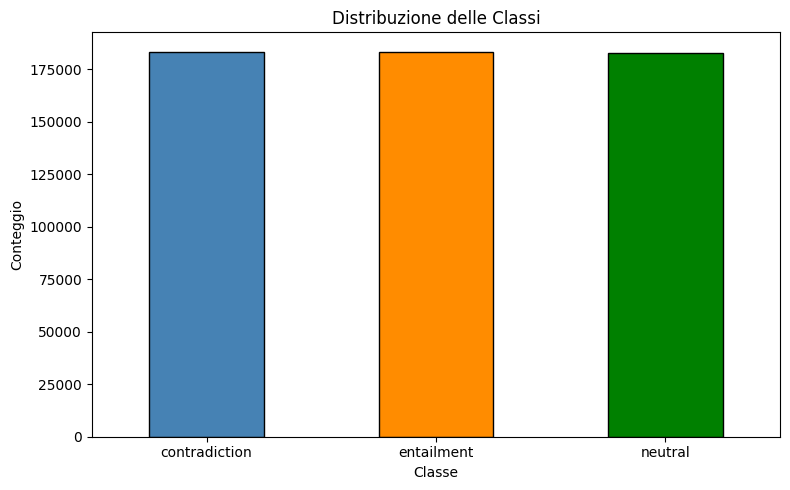

,gold_label,sentence1,sentence2
0,2,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,2,Children smiling and waving at camera,They are smiling at their parents
4,1,Children smiling and waving at camera,There are children present
5,0,Children smiling and waving at camera,The kids are frowning
6,0,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.
7,1,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.
8,2,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.
9,2,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...


Dev Set:
Lunghezza media delle frasi in sentence1: 13.94 parole
Lunghezza media delle frasi in sentence2: 7.51 parole


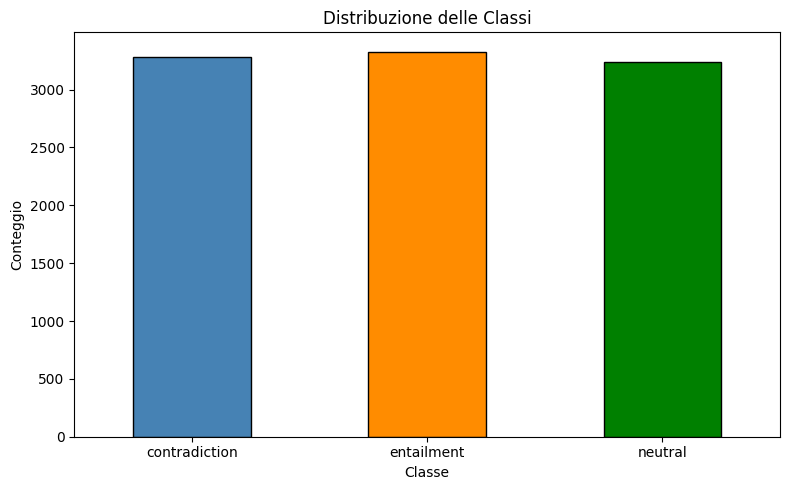

,gold_label,sentence1,sentence2
0,2,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...
1,1,Two women are embracing while holding to go pa...,Two woman are holding packages.
2,0,Two women are embracing while holding to go pa...,The men are fighting outside a deli.
3,1,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.
4,2,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.
5,0,"Two young children in blue jerseys, one with t...",Two kids in jackets walk to school.
6,0,A man selling donuts to a customer during a wo...,A woman drinks her coffee in a small cafe.
7,2,A man selling donuts to a customer during a wo...,A man selling donuts to a customer during a wo...
8,1,A man selling donuts to a customer during a wo...,A man selling donuts to a customer.
9,1,Two young boys of opposing teams play football...,boys play football


Test Set:
Lunghezza media delle frasi in sentence1: 13.91 parole
Lunghezza media delle frasi in sentence2: 7.48 parole


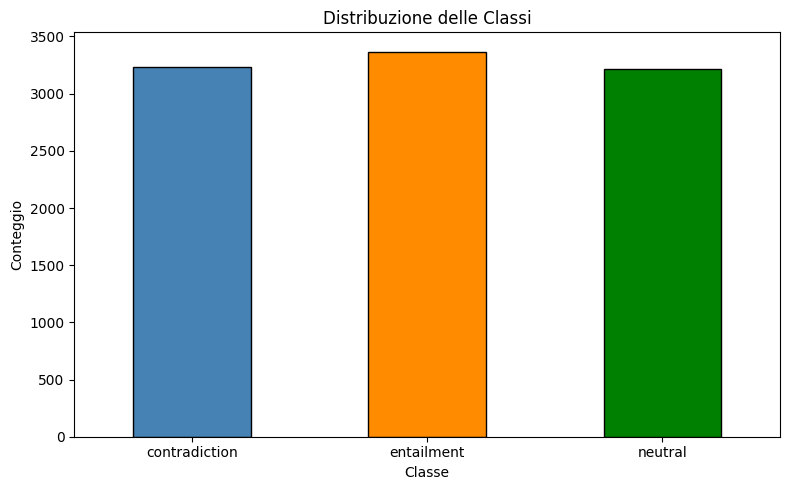

,gold_label,sentence1,sentence2
0,2,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,1,This church choir sings to the masses as they ...,The church is filled with song.
2,0,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,2,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,1,"A woman with a green headscarf, blue shirt and...",The woman is very happy.
5,0,"A woman with a green headscarf, blue shirt and...",The woman has been shot.
6,1,An old man with a package poses in front of an...,A man poses in front of an ad.
7,2,An old man with a package poses in front of an...,A man poses in front of an ad for beer.
8,0,An old man with a package poses in front of an...,A man walks by an ad.
9,2,A statue at a museum that no seems to be looki...,The statue is offensive and people are mad tha...


In [ ]:
def preprocess_data(df):
    # 1. Rimozione colonne inutili
    cols_to_remove = ["label1", "label2", "label3", "label4", "label5",'pairID','captionID','sentence1_binary_parse','sentence2_binary_parse','sentence1_parse','sentence2_parse']
    df = df.drop(columns=[col for col in cols_to_remove if col in df.columns], errors="ignore")

    # 2. Rimozione NaN
    df = df.dropna()

    # 3. Filtraggio di label valide
    valid_labels = {"contradiction", "entailment", "neutral"}
    df = df[df["gold_label"].isin(valid_labels)]

    # 5. Mapping di label a valori numerici
    label_mapping = {"contradiction": 0, "entailment": 1, "neutral": 2}
    df["gold_label"] = df["gold_label"].map(label_mapping)

    # 6. Calcolo e stampa della lunghezza delle frasi
    sentence1_lengths = df["sentence1"].apply(lambda x: len(x.split()))
    sentence2_lengths = df["sentence2"].apply(lambda x: len(x.split()))
    avg_sentence1_length = sentence1_lengths.mean()
    avg_sentence2_length = sentence2_lengths.mean()
    print(f"Lunghezza media delle frasi in sentence1: {avg_sentence1_length:.2f} parole")
    print(f"Lunghezza media delle frasi in sentence2: {avg_sentence2_length:.2f} parole")

    # 7. Distribuzione delle classi
    label_counts = df["gold_label"].value_counts().sort_index()
    # mappatura inversa per tornare ai nomi originali (da 0, 1, 2 a testo)
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    label_counts = label_counts.rename(index=reverse_label_mapping)
    # plot distribuzioni
    plt.figure(figsize=(8, 5))
    label_counts.plot(kind="bar", color=["steelblue", "darkorange", "green"], edgecolor="black")
    plt.title("Distribuzione delle Classi")
    plt.xlabel("Classe")
    plt.ylabel("Conteggio")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 8. Stampa prime righe del dataframe
    display(df.head(10))

    return df

# Esecuzione della funzione sui dataset
print('Train Set:')
train_df = preprocess_data(train_df)
print('Dev Set:')
dev_df = preprocess_data(dev_df)
print('Test Set:')
test_df = preprocess_data(test_df)

In [ ]:
# LOGISTIC REGRESSION CON OvR

# Campionamento dei dati
train_df_sampled = train_df.sample(frac=0.5, random_state=42)
dev_df_sampled = dev_df.sample(frac=0.5, random_state=42)
test_df_sampled = test_df.sample(frac=0.5, random_state=42)

In [ ]:
# TF-IDF Vectorizer
all_sentences = pd.concat([train_df['sentence1'], train_df['sentence2']])
vectorizer = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.9)
vectorizer.fit(all_sentences)

# Funzione per creare feature sparse e calcolo della cosine similarity
def create_sparse_features(df, vectorizer):
    s1_vecs = vectorizer.transform(df['sentence1'])
    s2_vecs = vectorizer.transform(df['sentence2'])
    cosine_sim = s1_vecs.multiply(s2_vecs).sum(axis=1)
    X = hstack([s1_vecs, s2_vecs, csr_matrix(cosine_sim)])
    y = df['gold_label'].values
    return X, y

X_train, y_train = create_sparse_features(train_df_sampled, vectorizer)
X_val, y_val     = create_sparse_features(dev_df_sampled, vectorizer)
X_test, y_test   = create_sparse_features(test_df_sampled, vectorizer)

In [ ]:
# Ricerca iperparametri e GridSearchCV
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__penalty': ['l2'],
    'estimator__solver': ['lbfgs', 'saga'],
    'estimator__max_iter': [500]
}

ovr_model = OneVsRestClassifier(LogisticRegression())
grid = GridSearchCV(ovr_model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("Migliori iperparametri:", grid.best_params_)

# Modello finale con i migliori parametri
model = grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Migliori iperparametri: {'estimator__C': 1, 'estimator__max_iter': 500, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}



 Train Report:
               precision    recall  f1-score   support

Contradiction     0.6926    0.6783    0.6854     91259
   Entailment     0.6762    0.7555    0.7137     91960
      Neutral     0.6795    0.6134    0.6448     91461

     accuracy                         0.6826    274680
    macro avg     0.6828    0.6824    0.6813    274680
 weighted avg     0.6828    0.6826    0.6813    274680


 Validation Report:
               precision    recall  f1-score   support

Contradiction     0.6597    0.6842    0.6717      1612
   Entailment     0.6952    0.7292    0.7118      1680
      Neutral     0.6705    0.6120    0.6399      1629

     accuracy                         0.6757      4921
    macro avg     0.6751    0.6751    0.6745      4921
 weighted avg     0.6754    0.6757    0.6749      4921


 Test Report:
               precision    recall  f1-score   support

Contradiction     0.6779    0.6830    0.6804      1596
   Entailment     0.6934    0.7400    0.7159      1708
      

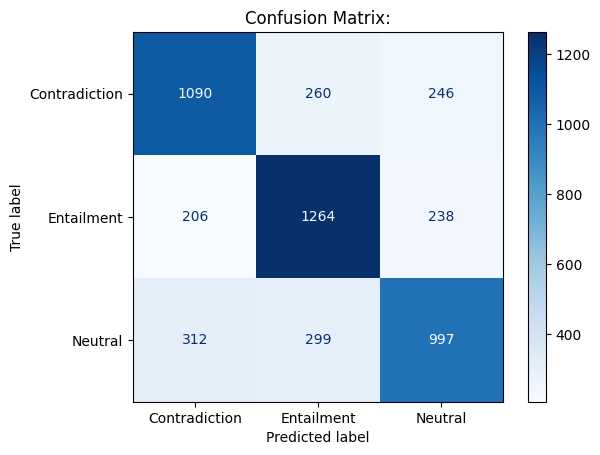

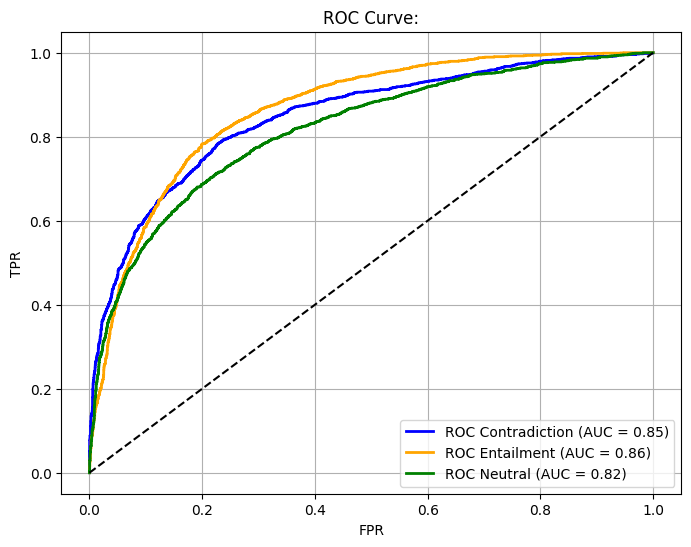

In [ ]:
# EVALUATION FINALE

# Classification Report
for name, X, y in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
    preds = model.predict(X)
    print(f"\n {name} Report:")
    print(classification_report(y, preds, digits=4, target_names=["Contradiction", "Entailment", "Neutral"]))

# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Contradiction", "Entailment", "Neutral"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix:")
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
probs = model.predict_proba(X_test)
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, label in enumerate(["Contradiction", "Entailment", "Neutral"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"ROC {label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve:")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#LSTM

# Costruzione del vocabolario
def build_vocab(sentences, max_size=10000, min_freq=2):
    freq = Counter()
    for s in sentences:
        freq.update(s.lower().split())
    vocab = [w for w,c in freq.most_common() if c >= min_freq][:max_size]
    word2idx = {w:i+2 for i,w in enumerate(vocab)}
    word2idx["<pad>"] = 0
    word2idx["<unk>"] = 1
    return word2idx

all_sents = pd.concat([train_df['sentence1'], train_df['sentence2'],
                       dev_df['sentence1'], dev_df['sentence2']])

# Frazionamento del dataset
train_df_reduced = train_df.sample(frac=0.5, random_state=42)
dev_df_reduced = dev_df.sample(frac=0.5, random_state=42)
test_df_reduced = test_df.sample(frac=0.5, random_state=42)

word2idx = build_vocab(pd.concat([train_df_reduced['sentence1'], train_df_reduced['sentence2'],
                                  dev_df_reduced['sentence1'], dev_df_reduced['sentence2']]),
                       max_size=10000, min_freq=2)
vocab_size = len(word2idx)


# TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)
tfidf_vect.fit(pd.concat([train_df_reduced['sentence1'], train_df_reduced['sentence2'],
                          dev_df_reduced['sentence1'],   dev_df_reduced['sentence2']]))

TfidfVectorizer(max_df=0.9, max_features=5000, min_df=5)

In [ ]:
# DATASET
class SNLIDatasetLSTM(Dataset):
    def __init__(self, df, word2idx, tfidf_vect):
        self.s1 = df['sentence1'].tolist()
        self.s2 = df['sentence2'].tolist()
        self.labels = df['gold_label'].values
        self.w2i = word2idx
        self.tfidf = tfidf_vect

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # tokenizzazione e mapping
        def tok2idx(sent):
            return [ self.w2i.get(w,1) for w in sent.lower().split() ]
        t1 = tok2idx(self.s1[idx])
        t2 = tok2idx(self.s2[idx])
        # cosine similarity
        v1 = self.tfidf.transform([self.s1[idx]])
        v2 = self.tfidf.transform([self.s2[idx]])
        cos = float(cosine_similarity(v1, v2)[0,0])

        # overlap
        tokens1 = set(self.s1[idx].lower().split())
        tokens2 = set(self.s2[idx].lower().split())
        overlap = len(tokens1 & tokens2) / (len(tokens1 | tokens2) + 1e-4)
        len_diff = abs(len(tokens1) - len(tokens2)) / (len(tokens1) + 1e-4)

        features = torch.tensor([cos, overlap, len_diff], dtype=torch.float32)
        return torch.tensor(t1, dtype=torch.long), \
              torch.tensor(t2, dtype=torch.long), \
              features, \
              torch.tensor(self.labels[idx], dtype=torch.long)

#COLLATE
def collate_fn(batch):
    t1, t2, cos, lab = zip(*batch)
    t1_pad = pad_sequence(t1, batch_first=True, padding_value=0)
    t2_pad = pad_sequence(t2, batch_first=True, padding_value=0)
    cos_t  = torch.stack(cos)
    lab_t  = torch.stack(lab)
    return t1_pad, t2_pad, cos_t, lab_t

In [ ]:
# LOADERS
batch_size = 64
train_ds = SNLIDatasetLSTM(train_df_reduced, word2idx, tfidf_vect)
dev_ds   = SNLIDatasetLSTM(dev_df_reduced,   word2idx, tfidf_vect)
test_ds  = SNLIDatasetLSTM(test_df_reduced,  word2idx, tfidf_vect)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader   = DataLoader(dev_ds,   batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=2, pin_memory=True)

In [ ]:
# DEFINIZIONE MODELLO LightningModule LSTM
class EntailmentLSTMModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, feature_dim, output_dim,
                 dropout_prob=0.5, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Embedding e BiLSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout_prob,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)

        # Dimensioni del Fully Connected Layer
        fc_input_dim = 16 * hidden_dim + feature_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

        # Loss e accuracy
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_dim)
        self.val_acc   = torchmetrics.Accuracy(task="multiclass", num_classes=output_dim)
        self.test_acc  = torchmetrics.Accuracy(task="multiclass", num_classes=output_dim)

        self.training_losses   = []
        self.validation_losses = []
        self._val_step_losses  = []

    #Forward
    def forward(self, t1, t2, cos_feat):
        e1, _ = self.lstm(self.embedding(t1))
        e2, _ = self.lstm(self.embedding(t2))

        # Prima frase
        h1_forward  = e1[:, -1, :self.hparams.hidden_dim]
        h1_backward = e1[:,  0, self.hparams.hidden_dim:]
        h1_maxpool  = e1.max(dim=1).values
        h1 = torch.cat([h1_forward, h1_backward, h1_maxpool], dim=1)

        # Seconda frase
        h2_forward  = e2[:, -1, :self.hparams.hidden_dim]
        h2_backward = e2[:,  0, self.hparams.hidden_dim:]
        h2_maxpool  = e2.max(dim=1).values
        h2 = torch.cat([h2_forward, h2_backward, h2_maxpool], dim=1)

        # Combinazione delle frasi
        diff = torch.abs(h1 - h2)
        prod = h1 * h2
        x = torch.cat([h1, h2, diff, prod, cos_feat], dim=1)
        x = self.dropout(x)
        return self.fc(x)

    def step(self, batch):
        t1, t2, cos, y = batch
        logits = self(t1, t2, cos)
        loss   = self.criterion(logits, y)
        preds  = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_acc.update(preds, y)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.val_acc.update(preds, y)
        return loss

    def test_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.test_acc.update(preds, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),
                                 lr=self.hparams.lr,
                                 weight_decay=1e-4)

In [ ]:
# CALLBACK per il tracciamento delle Loss
class LossCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        pl_module.training_losses.append(trainer.callback_metrics["train_loss"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        pl_module.validation_losses.append(trainer.callback_metrics["val_loss"].item())

In [ ]:
# ADDESTRAMENTO MODELLO

model = EntailmentLSTMModel(
    vocab_size=vocab_size,
    embedding_dim=200,
    hidden_dim=128,
    feature_dim=3,
    output_dim=3,
    dropout_prob=0.3,
    lr=1e-4
)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)

loss_cb = LossCallback()
trainer = pl.Trainer(
    max_epochs=6,
    accelerator="auto",
    devices=1,
    callbacks=[early_stop, loss_cb],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

In [ ]:
# EVALUATION FINALE

@torch.no_grad()
def get_preds_probs(model, loader):
    model.eval()
    Ys, Ps, PR = [], [], []
    for batch in loader:
        t1, t2, cos, y = batch
        t1, t2, cos, y = [x.to(model.device) for x in (t1,t2,cos,y)]
        logits = model(t1, t2, cos)
        probs  = torch.softmax(logits, dim=1)
        preds  = torch.argmax(probs, dim=1)
        Ys.extend(y.cpu().numpy())
        Ps.extend(preds.cpu().numpy())
        PR.append(probs.cpu().numpy())
    return np.array(Ys), np.array(Ps), np.vstack(PR)

# Classification report
for name, loader in [("TRAIN", train_loader), ("VAL", val_loader), ("TEST", test_loader)]:
    y_true, y_pred, y_prob = get_preds_probs(model, loader)
    print(f"\n {name} report:")
    print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
y_true, y_pred, y_prob = get_preds_probs(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Contradiction","Entailment","Neutral"])\
    .plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix:"); plt.show()

# ROC Curve
y_bin = label_binarize(y_true, classes=[0,1,2])
plt.figure(figsize=(8,6))
for i, lab in enumerate(["Contradiction","Entailment","Neutral"]):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve:"); plt.legend(); plt.grid(); plt.show()

# Curve di loss e verifica di Overfittin
plt.plot(model.training_losses, label="Train Loss")
plt.plot(model.validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves:")
plt.legend()
plt.grid(True)
plt.show()